# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.912658,True,5.694408
1,-0.900614,False,-0.591545
2,-0.043553,True,4.233569
3,-1.796172,False,-2.731980
4,-0.297849,False,-0.099592
...,...,...,...
995,-0.638019,False,0.559221
996,0.402586,True,4.448794
997,0.026179,False,0.361961
998,-2.104674,False,0.530919


<AxesSubplot: xlabel='v0'>

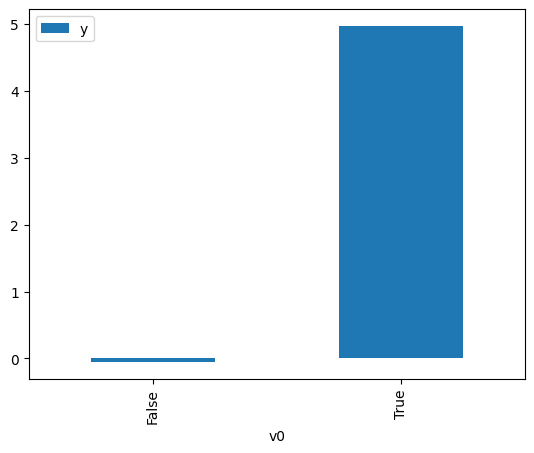

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

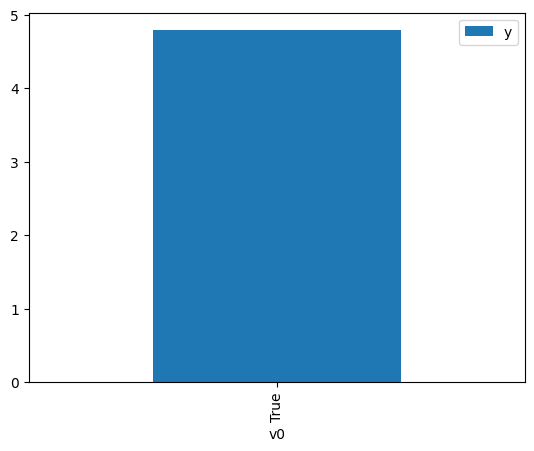

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.716986,False,0.853353,0.253359,3.946961
1,0.878501,False,1.005602,0.210469,4.751294
2,-0.557164,False,-0.901853,0.694870,1.439119
3,-0.220875,False,-0.930800,0.579451,1.725770
4,-1.252532,False,-1.471816,0.865526,1.155367
...,...,...,...,...,...
995,0.662193,False,-0.147111,0.269157,3.715310
996,-0.001361,False,2.042363,0.498134,2.007491
997,-1.478533,False,1.260399,0.900217,1.110843
998,-0.042659,False,-0.211783,0.513557,1.947203


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.259315,True,4.113292,0.406620,2.459300
1,0.391235,True,3.979037,0.644296,1.552083
2,-0.833256,True,4.429824,0.225219,4.440122
3,0.183443,True,7.342513,0.570425,1.753078
4,-0.976911,True,4.899268,0.189979,5.263740
...,...,...,...,...,...
995,-1.215434,True,3.481696,0.141058,7.089307
996,0.275913,True,5.332709,0.603902,1.655898
997,-0.543243,True,3.421775,0.309558,3.230410
998,-0.654070,True,5.237350,0.275324,3.632085


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              5169.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):                        0.00
Time:                        14:50:34   Log-Likelihood:                         -1404.2
No. Observations:                1000   AIC:                                      2812.
Df Residuals:                     998   BIC:                                      2822.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2408      0.030      8.088      0.000       0.182       0.299
x2             4.9804      0.050     99.264      0.000       4.882       5.079
==============================================================================
Omnibus:                        0.643   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.725   Jarque-Bera (JB):                0.719
Skew:                           0.005   Prob(JB):                        0.698
Kurtosis:                       2.869   Cond. No.                         1.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""